<a href="https://colab.research.google.com/github/waynchi/SC-Net/blob/master/SC_CNN_mnist_double_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install mnist
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf
tf.test.is_gpu_available()


True

# What about a GAN + Self correcting U-Net ? That would make for a cool architecture
# Following CGAN -> adding a 1-hot vector encoding of the label to the training data
# Simulated Annealing?
# Generator -> VAE -> Discriminator?
# What about feeding in a dicriminator's confidence level as a temperature during the autoregressive? Inverse confidence?
# What about a 3 dimensional GAN?
# What about adding attention to the model?

# Umut Notes
- Add a stop condition to the softmax
    - Tried both 2 outputs and just an extra variable to the softmax
    - 2 outputs fails due to it having too much weight to the loss and the loss fluctuates like crazy
    - extra variable fails as the probability is still small even for an original image. Not sure why. Maybe because each time wew generate we use a new random which causes the dataset to be imbalanced?
- 2 steps process (pick note and then choose how much through binary cross entropy)

In [0]:
import mnist
import scipy.misc
from PIL import Image
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
from keras.datasets import cifar10


def make_grayscale(data, dtype=np.float32):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    rst = rst.astype(np.uint8)
    return rst

def create_image(image, name, image_shape=(32, 32), is_grayscale=True):
    img_arr = deepcopy(image.reshape(image_shape)).astype(np.uint8)

    img = Image.fromarray(img_arr.astype(np.uint8), 'L')
    # pprint(img_arr)
    # print("img shape: {}. img sum: {}".format(img_arr.shape, img_arr.sum()))
    img.save(name)
    return img

is_single = False
is_grayscale = True
is_cifar_10 = False

if is_single:
    num_samples = 8
else:
    num_samples = 60000

if is_cifar_10:
    (images, labels), (_, _) = cifar10.load_data()
    images = make_grayscale(images)
else:
    images = mnist.train_images()

    # np.random.shuffle(images)
images = images[:num_samples, :, :]


if not is_grayscale:
    # For black and white
    images[images > 0] = 1
    # images = images / 255.0

# pprint(images)
print(images.shape)

# labels = mnist.train_labels()
# n_labels = np.max(labels) + 1
# labels = np.eye(n_labels)[labels]
# print(labels.shape)

if is_cifar_10:
    image_shape = images[0].shape
else:
    image_shape = np.expand_dims(images[0], axis=-1).shape 

print(images[0])
create_image(images[0], 'my.png', image_shape=image_shape[:-1], is_grayscale=is_grayscale)
print(image_shape)

(60000, 28, 28)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 25

In [0]:
def to_one_hot(arr):
    arr = deepcopy(arr)
    arr = arr.astype(np.uint8)
    n_values = 256
    one_hot = np.eye(n_values)[arr]
    one_hot = one_hot.astype(np.uint8)
    return one_hot

one_hot = to_one_hot(images[0])
print(one_hot.shape)

argmax_res = np.argmax(one_hot, axis=-1)
print(argmax_res)


(28, 28, 256)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 

In [0]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Flatten, Dense, Softmax, Reshape, Activation
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import backend as K
from tensorflow.python.ops import math_ops

def built_in_softmax_kl_loss(target, output):
    target = K.flatten(target)
    output = K.flatten(output)
    
    target = target / K.sum(target)
    output = K.softmax(output)
    return keras.losses.kullback_leibler_divergence(target, output)

keras.losses.built_in_softmax_kl_loss = built_in_softmax_kl_loss

def conv_layer(n_filters, filter_size, conv):
    conv = Conv2D(n_filters, filter_size, activation='relu', padding='same')(conv)
    conv = Conv2D(n_filters, filter_size, activation='relu', padding='same')(conv)
    conv = Conv2D(n_filters, filter_size, activation='relu', padding='same')(conv)
    return conv
 
def unet_model(input_size=(28, 28, 1), n_filters_start=32, growth_factor=2,
               upconv=False, is_grayscale=True, num_sub_layers=3):
    droprate=0.5
    n_filters = n_filters_start
    inputs = Input(input_size)
    conv_first = conv_layer(n_filters, (3, 3), inputs)
    pool_first = MaxPooling2D(pool_size=(2, 2))(conv_first)

    prev_pool = pool_first
    hidden_layers = []
    for _ in range(1):
        n_filters *= growth_factor
        pool = BatchNormalization()(prev_pool)
        conv = conv_layer(n_filters, (3, 3), pool)
        pool = MaxPooling2D(pool_size=(2, 2))(conv)
        pool = Dropout(droprate)(pool)
        prev_pool = pool
        hidden_layers.append(conv)
 
    n_filters *= growth_factor
    conv_mid = conv_layer(n_filters, (3, 3), prev_pool)
 
    n_filters //= growth_factor
    if upconv:
        up_first = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv_mid), hidden_layers[-1]])
    else:
        up_first = concatenate([UpSampling2D(size=(2, 2))(conv_mid), hidden_layers[-1]])
    up_first = BatchNormalization()(up_first)
    conv_mid_2 = conv_layer(n_filters, (3, 3), up_first)
    conv_mid_2 = Dropout(droprate)(conv_mid_2)

    prev_conv = conv_mid_2
    for i in range(0):
        n_filters //= growth_factor
        if upconv:
            up = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(prev_conv), hidden_layers[-i-2]])
        else:
            up = concatenate([UpSampling2D(size=(2, 2))(prev_conv), hidden_layers[-i-2]])
        up = BatchNormalization()(up)
        conv = conv_layer(n_filters, (3, 3), up)
        conv = Dropout(droprate)(conv)
        prev_conv = conv
 
    n_filters //= growth_factor
    if upconv:
        up_last = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv_mid_2), conv_first])
    else:
        up_last = concatenate([UpSampling2D(size=(2, 2))(conv_mid_2), conv_first])
    conv_last = conv_layer(n_filters, (3, 3), up_last)
 
    softmax_out = Conv2D(1, 1, activation='linear', name='softmax_out')(conv_last)

    if is_grayscale:
        sigmoid_out = Conv2D(256, 1, padding='valid', name='sigmoid_out')(conv_last)
        sigmoid_out = Reshape((*image_shape[:-1], 256))(sigmoid_out)
        sigmoid_out = Activation('softmax')(sigmoid_out)
        # sigmoid_out = Flatten()(conv_last)
        # sigmoid_out = Dense(np.prod(input_size), activation='sigmoid')(sigmoid_out)
        # sigmoid_out = Reshape(input_size)(sigmoid_out)
        model = Model(inputs=inputs, outputs=[softmax_out, sigmoid_out])
        model.compile(optimizer=Adam(lr=0.001), loss=[built_in_softmax_kl_loss, 'categorical_crossentropy'], metrics=['accuracy'])
    else:
        model = Model(inputs=inputs, outputs=softmax_out)
        model.compile(optimizer=Adam(), loss=built_in_softmax_kl_loss)

    # model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [0]:
model = unet_model(input_size=image_shape, is_grayscale=is_grayscale)

Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_766 (Conv2D)             (None, 28, 28, 32)   320         input_52[0][0]                   
__________________________________________________________________________________________________
conv2d_767 (Conv2D)             (None, 28, 28, 32)   9248        conv2d_766[0][0]                 
__________________________________________________________________________________________________
conv2d_768 (Conv2D)             (None, 28, 28, 32)   9248        conv2d_767[0][0]                 
___________________________________________________________________________________________

In [0]:
# discriminator_model = discriminator(input_size=image_shape)

In [0]:
from copy import deepcopy
import math
import itertools
import time
import random

def mask_image_with_noise(image, is_grayscale=True):
    image = deepcopy(image)
    sampling_percentage_mask = np.random.uniform(0, 100)
    sampling_percentage_noise = np.random.uniform(0, 5)
    non_zero = np.nonzero(image)
    mask = np.full(len(non_zero[0]), False)
    noise = np.full(len(non_zero[0]), False)
    amount_to_mask = math.floor(len(non_zero[0]) * (sampling_percentage_mask / 100.0))
    mask[:amount_to_mask] = True
    amount_of_noise = math.floor(len(non_zero[0]) * (sampling_percentage_noise / 100.0))
    noise[:amount_of_noise] = True
    np.random.shuffle(mask)
    np.random.shuffle(noise)
    # pprint(mask1)
    output_image = deepcopy(image)
    xor_target = np.full(output_image.shape, False)

    r1 = list(itertools.compress(non_zero[0], mask))
    c1 = list(itertools.compress(non_zero[1], mask))
    output_image[r1, c1] = 0
    xor_target[r1, c1] = True

    # There might be overlap but that is ok
    r2 = list(itertools.compress(non_zero[0], noise))
    c2 = list(itertools.compress(non_zero[1], noise))
    random_values = np.random.uniform(0, 1, (len(r2), 1))
    random_values *= 255
    random_values = np.around(random_values)
    random_values = random_values.astype(np.uint8)
    # random_values /= 255
    output_image[r2, c2] = random_values
    xor_target[r2, c2] = True

    return output_image, xor_target


class ImageGenerator(keras.utils.Sequence):
    def __init__(self, sample_list, image_shape, batch_size, samples_per_data_item, stops_per_data_item, is_grayscale=True, seed=None):
        print("sample_list: {}".format(len(sample_list)))
        self.sample_list = sample_list
        self.image_shape = image_shape
        self.batch_size = batch_size
        self.samples_per_data_item = samples_per_data_item
        self.stops_per_data_item = stops_per_data_item
        self.is_grayscale = is_grayscale
        self.sample_index = 0
        self.seed = seed
        self.dtype = np.uint8
        # if self.seed is not None:
        #     np.random.seed(self.seed)

    def generate_training_pairs(self):
        '''
        Generates Training Pairs till @training_input / @training_target have @batch_size files.
        '''
        training_input = []
        training_original = []
        training_target = []
        while len(training_input) < self.batch_size:
            original_image = deepcopy(self.sample_list[self.sample_index])
            original_image = original_image.reshape(self.image_shape)
            binary_image = deepcopy(original_image)
            binary_image[binary_image > 0] = 1
            self.sample_index = (self.sample_index + 1) % len(self.sample_list)
            # print("sample_list length: {}. sample_index: {}".format(
            #     len(self.sample_list), self.sample_index))
            try:
                # augment by adding and removing random values in the array

                # Add random values
                for _ in range(self.samples_per_data_item):
                    original_image = original_image.astype(self.dtype)
                    input_image, xor_target = mask_image_with_noise(original_image, is_grayscale=self.is_grayscale)

                    input_image = input_image.astype(self.dtype)
                    xor_target = xor_target.astype(self.dtype)

                    training_input.append(deepcopy(input_image))
                    training_original.append(to_one_hot(np.squeeze(original_image)))
                    # training_original.append(deepcopy(original_image))
                    training_target.append(deepcopy(xor_target))

            except Exception as e:
                print('Error generating input and target pair')
                traceback.print_exc()
        training_input = np.asarray(training_input)
        training_target = np.asarray(training_target)
        training_original = np.asarray(training_original)
        return training_input, training_target, training_original

    def save_image(self, img_arr, img_name):
        # img_arr = img_arr.reshape(self.image_shape)
        print(img_name)
        print("img shape: {}. img sum: {}".format(img_arr.shape, img_arr.sum()))
        img_arr = img_arr[:, :, 0]
        print("img shape: {}. img sum: {}".format(img_arr.shape, img_arr.sum()))
        print(img_arr)
        #pprint(img_arr)
        print("img shape: {}. img sum: {}".format(img_arr.shape, img_arr.sum()))
        img = Image.fromarray(img_arr.astype(np.uint8), 'L')
        img.save(img_name)

    def get_random_training_pair(self):
        training_input, training_target, training_original = self.generate_training_pairs()
        print("training_input shape: {}".format(training_input.shape))
        index = random.randrange(0, len(training_input))
        self.save_image(deepcopy(training_input[index]), 'training_input.png')
        self.save_image(deepcopy(training_target[index]) * 255, 'training_target.png')
        print(training_original.shape)
        original_image = deepcopy(training_original[index])
        original_image = np.argmax(original_image, axis=-1)
        print(original_image.shape)
        original_image = np.expand_dims(original_image, axis=-1)
        self.save_image(original_image, 'training_original.png')

    def generate_validation_samples(self):
        old_batch_size = self.batch_size
        self.batch_size = len(self.sample_list) * (self.samples_per_data_item + self.stops_per_data_item)
        training_input, training_target, training_original = self.generate_training_pairs()
        # training_input = np.asarray(self.training_input[:self.batch_size])
        # training_target = np.asarray(self.training_target[:self.batch_size])
        self.batch_size = old_batch_size
        if self.is_grayscale:
            return training_input, [training_target, training_original]
        else:
            return training_input, training_target

    def __getitem__(self, index):
        '''Generates 1 batch of data'''
        training_input, training_target, training_original = self.generate_training_pairs()
        # training_input = np.asarray(self.training_input[:self.batch_size])
        # training_target = np.asarray(self.training_target[:self.batch_size])
        # self.training_input = self.training_input[self.batch_size:]
        # self.training_target = self.training_target[self.batch_size:]
        # print("training input sum: {}. target sum: {}".format(training_input.sum(), training_target.sum()))
        if is_grayscale:
            return training_input, [training_target, training_original]
        else:
            return np.asarray(training_input), np.asarray(training_target)

    def __len__(self):
        '''Number of batches / epoch'''
        # print("sample_list: {}. samples_per_data_item: {}, batch size: {}".
        #       format(len(self.sample_list), self.samples_per_data_item,
        #              self.batch_size))
        samples_to_generate = int(
            (len(self.sample_list) * (self.samples_per_data_item + self.stops_per_data_item)) /
            self.batch_size)
        # print("samples to generate: {}".format(samples_to_generate))
        return samples_to_generate
    
    # def on_epoch_begin(self):
    #     if self.seed is not None:
    #         np.random.seed(self.seed)
    #     else:
    #         np.random.seed(time.time())


In [0]:
# Config
stops_per_data_item = 0
if is_single:
    batch_size = 8
    samples_per_data_item = 1
    split = 1
else:
    batch_size = 128
    samples_per_data_item = 1
    split = 0.9

In [0]:
training_samples = images[:int(len(images) * split)]
validation_samples = images[int(len(images) * split):]

print("training samples: {}. validation samples: {}".format(len(training_samples), len(validation_samples)))

steps_per_epoch = int(len(training_samples) * (samples_per_data_item + stops_per_data_item) / batch_size)
print("steps per epoch: {}".format(steps_per_epoch))

# pprint(training_samples[0])

training_generator = ImageGenerator(
    sample_list=training_samples,
    image_shape=image_shape,
    batch_size=batch_size,
    samples_per_data_item=samples_per_data_item,
    stops_per_data_item=stops_per_data_item,
    is_grayscale=is_grayscale)

validation_generator = ImageGenerator(
    sample_list=validation_samples,
    image_shape=image_shape,
    batch_size=batch_size,
    samples_per_data_item=samples_per_data_item,
    stops_per_data_item=stops_per_data_item,
    is_grayscale=is_grayscale)

validation_data = validation_generator.generate_validation_samples()

# print("validation data input and target shape: {}".format(validation_data[0].shape))




training samples: 54000. validation samples: 6000
steps per epoch: 421
sample_list: 54000
sample_list: 6000


In [0]:
training_generator.get_random_training_pair()

training_input shape: (128, 28, 28, 1)
training_input.png
img shape: (28, 28, 1). img sum: 16302
img shape: (28, 28). img sum: 16302
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  23  79 192
    0 216  91   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 252   0
  252 252   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 147 209 252 252   0
  168  80  31   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  38 175   0   0 214   0  25
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 19

In [0]:
model_location = F'/content/drive/My Drive/sc-model-es-net-mnist-grayscale-double-softmax.hdf5'
log_dir = F'/content/drive/My Drive/logs'

In [0]:
# updatable plot
# a minimal example
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.xscale('log')
        plt.show();
        
plot_losses = PlotLosses()

In [0]:
import os

model = unet_model(input_size=image_shape, is_grayscale=is_grayscale)

resume_training = False
if resume_training:
    model = keras.models.load_model(model_location)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=model_location,
    monitor='val_loss',
    save_weights_only=False,
    verbose=1,
    mode='min',
    save_best_only=False)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='epoch')

if True:
    if is_single:
        history = model.fit(
            training_generator,
            # validation_data=validation_data,
            verbose=1,
            shuffle=True,
            steps_per_epoch=steps_per_epoch,
            epochs=3000,
            callbacks=[model_checkpoint_callback])#, tensorboard_callback])
    else:
        history = model.fit(
            training_generator,
            validation_data=validation_data,
            verbose=1,
            shuffle=True,
            steps_per_epoch=steps_per_epoch,
            epochs=1000,
            callbacks=[model_checkpoint_callback, plot_losses, tensorboard_callback])#, tensorboard_callback])
    #epochs=cfg.epochs,
    #callbacks=callbacks)
# model.save("sc-model.hdf5")

Model: "model_54"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_796 (Conv2D)             (None, 28, 28, 32)   320         input_54[0][0]                   
__________________________________________________________________________________________________
conv2d_797 (Conv2D)             (None, 28, 28, 32)   9248        conv2d_796[0][0]                 
__________________________________________________________________________________________________
conv2d_798 (Conv2D)             (None, 28, 28, 32)   9248        conv2d_797[0][0]                 
___________________________________________________________________________________________

KeyboardInterrupt: ignored



1.   Loss
  1. 
2.   List item



In [0]:
# "Loss"
if is_single:
    plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    # plt.xscale('log')
    plt.show()

# Inference

(28, 28, 1)


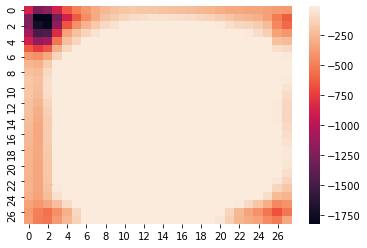

(1, 28, 28, 256)
(1, 28, 28)


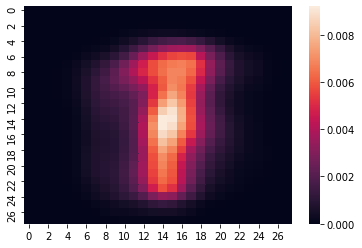

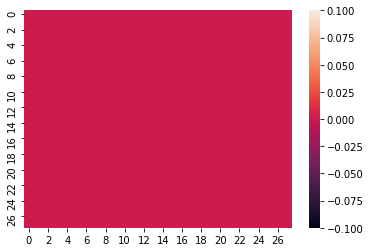

In [0]:
# testing model predict with seaborn and plots
model = keras.models.load_model(model_location)
import seaborn as  sb
import matplotlib.pyplot as plt
print(image_shape)
def generate_noise():
    input_image = np.full(image_shape, 0)
    # input_image = np.expand_dims(images[0], -1)

    # Random noise
    # input_image = np.random.rand(28, 28)
    # input_image[input_image >= 0.5] = 1
    # input_image[input_image < 0.5] = 0

    input_image = input_image.astype(np.uint8)
    input_image = np.expand_dims(input_image, 0)
    return input_image

test_image = generate_noise()
if is_grayscale:
    softmax_predictions, sigmoid_predictions = model.predict(test_image)
    softmax_predictions = softmax_predictions.reshape(image_shape[0], image_shape[1])
    heatmap = sb.heatmap(softmax_predictions)
    plt.show()
    softmax_predictions = np.exp(softmax_predictions)
    softmax_predictions = softmax_predictions / np.sum(softmax_predictions)
    print(sigmoid_predictions.shape)
    # print(sigmoid_predictions[])
    sigmoid_predictions = np.argmax(sigmoid_predictions, axis=-1)
    print(sigmoid_predictions.shape)
    sigmoid_predictions = sigmoid_predictions.reshape(image_shape[0], image_shape[1])
    heatmap = sb.heatmap(softmax_predictions)
    plt.show()
    heatmap = sb.heatmap(sigmoid_predictions)
    plt.show()
else:
    softmax_predictions = model.predict(test_image)
    softmax_predictions = softmax_predictions.reshape(28, 28)
    softmax_predictions = np.exp(softmax_predictions)
    softmax_predictions = softmax_predictions / np.sum(softmax_predictions)
    heatmap = sb.heatmap(softmax_predictions)
    plt.show()



In [0]:
import os
import shutil
import time


def inference(model, input_image, directory, iterations, temp_start=2, temp_end=0.5, top_k=250, is_grayscale=True, is_debug=False):
    create_image(input_image, "{}/input.png".format(directory), image_shape=image_shape[:-1])

    # temperatures = np.linspace(temp_start, temp_end, num=iterations)
    temperatures = np.geomspace(temp_start, temp_end, num=iterations)
    temperatures_reverse = (temp_start + temp_end) - temperatures[::-1]
    temperatures = np.concatenate((temperatures_reverse[:int(temperatures.shape[0]/2)], temperatures[int(temperatures.shape[0]/2):]))
    
    working_image = deepcopy(input_image)
    working_images = []
    num_added = 0
    num_removed = 0
    for i in range(iterations):
        temp = temperatures[i]            
        binary_image = deepcopy(working_image)
        binary_image[binary_image > 0] = 1
        if is_grayscale:
            softmax_predictions, sigmoid_predictions = model.predict(working_image)
        else:
            softmax_predictions = model.predict(binary_image)

        softmax_predictions = softmax_predictions.flatten()
        if is_grayscale:
            # sigmoid_predictions = np.argmax(sigmoid_predictions, axis=-1)
            sigmoid_predictions = sigmoid_predictions.reshape(-1, 256)

        softmax_predictions = np.exp(softmax_predictions / temp)
        softmax_predictions = softmax_predictions / np.sum(softmax_predictions)
        # softmax_predictions = np.nan_to_num(softmax_predictions)
        # print(softmax_predictions)
        # print(softmax_predictions[-1])
        indices = np.arange(softmax_predictions.shape[0])

        zipped = zip(softmax_predictions, indices)
        zipped = list(reversed(sorted(zipped, key = lambda x : x[0])))
        zipped = zipped[:top_k]
        zipped = sorted(zipped, key=lambda x : x[1])
        softmax_predictions, indices = zip(*zipped)
        softmax_predictions = np.asarray(softmax_predictions)
        softmax_predictions = softmax_predictions / np.sum(softmax_predictions)
        indices = np.asarray(indices)

        index = np.random.choice(indices, p=softmax_predictions)
        working_image = working_image.flatten()
        # if index == softmax_predictions.shape[0]:
        #     print("stopping")
            # break
        if is_grayscale:
            if working_image[index] != 0:
                num_removed += 1
            elif working_image[index] == 0:
                num_added += 1
            sigmoid_probs = sigmoid_predictions[index]
            sigmoid_indices = np.arange(sigmoid_probs.shape[0])
            working_image[index] = np.random.choice(sigmoid_indices, p=sigmoid_probs)
        else:
            if working_image[index] == 1:
                num_removed += 1
                working_image[index] = 0
            elif working_image[index] == 0:
                num_added += 1
                working_image[index] = 1
            else:
                print(working_image[index])
        working_image = np.reshape(working_image, [1, *image_shape])
        if i % 10 == 0:
            if is_debug:
                print("softmax")
                softmax_predictions = softmax_predictions.reshape(image_shape[:-1])
                heatmap = sb.heatmap(deepcopy(softmax_predictions))
                plt.show()
                print("sigmoid")
                sigmoid_predictions = np.argmax(sigmoid_predictions, axis=-1).reshape(image_shape[:-1])
                heatmap = sb.heatmap(deepcopy(sigmoid_predictions))
                plt.show()
            create_image(working_image, os.path.join(directory, "working_{}.png".format(i)), image_shape=image_shape[:-1])

    final_image = working_image
    final_binary_image = deepcopy(final_image)
    final_binary_image[final_binary_image > 0] = 1
    create_image(final_binary_image, os.path.join(directory, "final_binary.png"), image_shape=image_shape[:-1])

    print(final_image.shape)
    print("num added: {}. num removed: {}".format(num_added, num_removed))
    img = create_image(final_image, os.path.join(directory, 'final.png'), image_shape=image_shape[:-1])
    return img, deepcopy(final_image)

In [568]:
# model = keras.models.load_model(model_location)

drive_folder = '/content/drive/My Drive'

model_names = [# 'sc-model-es-net-60000-4',
               #'sc-model-es-net-60000-16',
               'sc-model-es-net-mnist-grayscale-double-softmax',
               #'sc-model-nade-60000-4'
               ]

config = {
    'sc-model-es-net-60000-4': {
        "iterations": 300,
        "temp_start": 0.99,
        "temp_end": 0.99,
        "top_k": 10000
    },
    'sc-model-es-net-mnist-grayscale-double-softmax': {
        "iterations": 500,
        "temp_start": 5,
        "temp_end": 2,
        "top_k": 10000
    },
    'sc-model-nade-60000-4': {
        "iterations": 170,
        "temp_start": 0.99,
        "temp_end": 0.99,
        "top_k" : 10000
    },

}

sample_sqrt = 5
for model_name in model_names:
    model = keras.models.load_model(os.path.join(drive_folder, model_name + '.hdf5'))
    model_config = config[model_name]
    generated_images = []
    for i in range(sample_sqrt**2):
        directory = "images_{}".format(i)
        os.makedirs(directory, exist_ok=True)
        input_image = generate_noise()
        # input_image = np.expand_dims(np.expand_dims(images[i], 0), -1)

        img, _ = inference(model, input_image, directory, 
                           model_config['iterations'], temp_start=model_config['temp_start'], 
                           temp_end=model_config['temp_end'], top_k=model_config['top_k'], 
                           is_grayscale=is_grayscale, is_debug=False)
        generated_images.append(img)
    
    final_im = Image.new('RGB', (28 * sample_sqrt, 28 * sample_sqrt))

    y_offset = 0
    for i in range(sample_sqrt):
        x_offset = 0
        new_im = Image.new('RGB', (28 * sample_sqrt, 28))
        for j in range(sample_sqrt):
            im = deepcopy(generated_images[(i * sample_sqrt) + j])
            new_im.paste(im, (x_offset, 0))
            x_offset += 28
        final_im.paste(new_im, (0, y_offset))
        y_offset += 28
        
    final_im.save(model_name + '.png')

(1, 28, 28, 1)
num added: 297. num removed: 203
(1, 28, 28, 1)
num added: 272. num removed: 228
(1, 28, 28, 1)
num added: 305. num removed: 195
(1, 28, 28, 1)
num added: 283. num removed: 217
(1, 28, 28, 1)
num added: 282. num removed: 218
(1, 28, 28, 1)
num added: 223. num removed: 277
(1, 28, 28, 1)
num added: 253. num removed: 247
(1, 28, 28, 1)
num added: 294. num removed: 206
(1, 28, 28, 1)
num added: 300. num removed: 200
(1, 28, 28, 1)
num added: 193. num removed: 307
(1, 28, 28, 1)
num added: 305. num removed: 195
(1, 28, 28, 1)
num added: 222. num removed: 278
(1, 28, 28, 1)
num added: 252. num removed: 248
(1, 28, 28, 1)
num added: 270. num removed: 230
(1, 28, 28, 1)
num added: 343. num removed: 157
(1, 28, 28, 1)
num added: 290. num removed: 210
(1, 28, 28, 1)
num added: 225. num removed: 275
(1, 28, 28, 1)
num added: 247. num removed: 253
(1, 28, 28, 1)
num added: 329. num removed: 171
(1, 28, 28, 1)
num added: 236. num removed: 264
(1, 28, 28, 1)
num added: 239. num remov